In [69]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [70]:
df = pd.read_csv("../DATA/stunting.csv")

df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


# Preprocessing Data

In [71]:
df.isnull().sum()
df.duplicated().sum()
df.drop_duplicates()

df["Stunting"].unique()

df["Jenis Kelamin"].unique()

map_stunt = {"Stunted": 1, "Severely Stunted": 1, "Normal": 0, "Tall": 0}
df["Stunting_bin"] = df["Stunting"].map(map_stunt).astype("Int64")

df["JK_bin"] = (df["Jenis Kelamin"] == "Laki-laki").astype(int)

print("Distribusi Stunting_bin:\n", df["Stunting_bin"].value_counts())
print("\nDistribusi JK_bin:\n", df["JK_bin"].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    21979
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [72]:
coor_matrix = df.corr(numeric_only=True)
coor_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


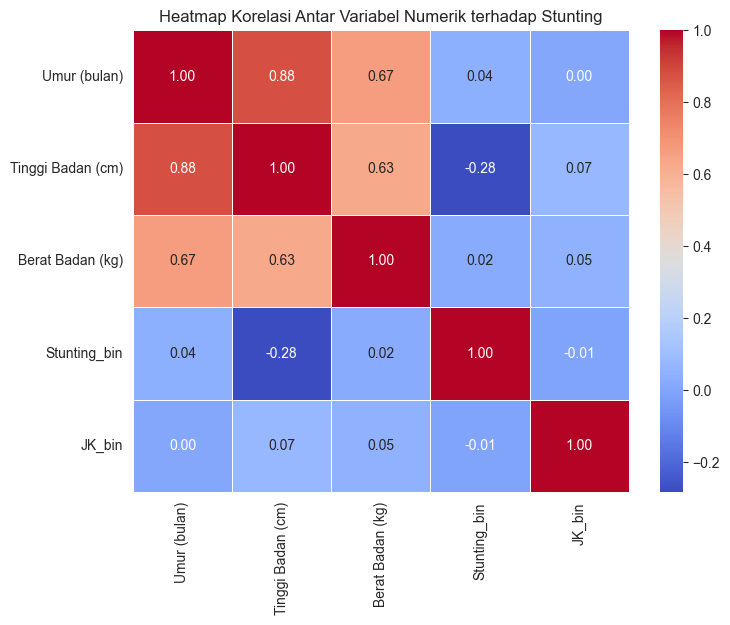

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(coor_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting")
plt.show()

# Pembagian Dataset

In [74]:
# Fitur numerik dan gender
feature_num = ["Umur (bulan)", "Tinggi Badan (cm)", "Berat Badan (kg)"]
feature_bin = ["JK_bin"]

use_cols = feature_bin + feature_num + ["Stunting_bin"]
df_model = df[use_cols].dropna().copy()

X = df_model[feature_bin + feature_num]
y = df_model["Stunting_bin"]

print("x shape:", X.shape)
print("y shape:", y.shape)

x shape: (100000, 4)
y shape: (100000,)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (80000, 4) (80000,)
Testing set: (20000, 4) (20000,)


In [76]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_num),
        ("bin", "passthrough", feature_bin),
    ],
    remainder="drop"
)

model = LogisticRegression(
    max_iter=1000, solver="lbfgs", class_weight="balanced", random_state=42
)

clf = Pipeline([
    ("preprocess", preprocess),
    ("model", model),
])

clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [77]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)

print("Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Model Evaluation:
Accuracy: 0.9055
Precision: 0.7152
Recall: 0.9472
F1 Score: 0.8150
ROC AUC: 0.9656


# Visualisasi Hasil

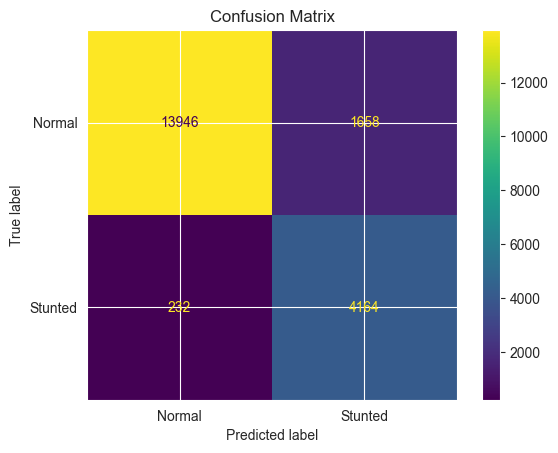

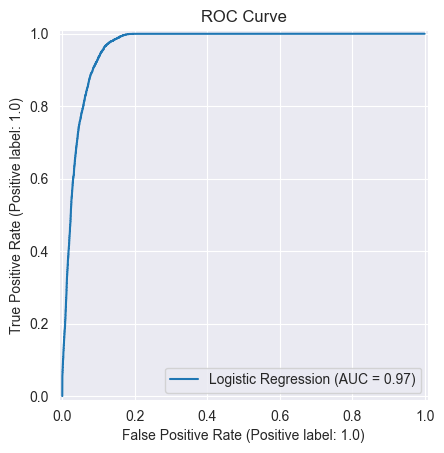

In [78]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred),
    display_labels=["Normal", "Stunted"]
).plot(
    values_format="d"
)

plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_estimator(
    clf, X_test, y_test, name="Logistic Regression"
)

plt.title("ROC Curve")
plt.show()

# Classification Report

In [79]:
print(
    classification_report(
        y_test, y_pred, target_names=["Tidak Stunting (0)", "Stunting (1)"],
    )
)

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.89      0.94     15604
      Stunting (1)       0.72      0.95      0.82      4396

          accuracy                           0.91     20000
         macro avg       0.85      0.92      0.88     20000
      weighted avg       0.92      0.91      0.91     20000



In [80]:
scores = cross_val_score(
    clf, X, y, cv=5
)

print(f"Skor tiap fold: {scores}")
print(f"Rata-rata akurasi: {np.mean(scores):.4f}")
print(f"Standar deviasi: {np.std(scores):.4f}")

Skor tiap fold: [0.9062  0.9013  0.9052  0.89905 0.9002 ]
Rata-rata akurasi: 0.9024
Standar deviasi: 0.0028


# Interpretasi Model Logistic Regression

In [83]:
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien': coefs,
    'Odds Ratio': odds
}).sort_values('Odds Ratio', ascending=False)

coef_df

,Fitur,Koefisien,Odds Ratio
0,Umur (bulan),8.525912,5043.782458
3,JK_bin,1.675944,5.343839
2,Berat Badan (kg),0.661090,1.936903
1,Tinggi Badan (cm),-10.535980,0.000027


# Prediksi Data Baru

In [82]:
new_data = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]  # 1: Laki-laki, 0: Perempuan
})

predictions = clf.predict(new_data)
probabilities = clf.predict_proba(new_data)[:, 1]

result = new_data.copy()
result['Prediksi'] = predictions
result['Probabilitas'] = probabilities

result

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prediksi,Probabilitas
0,24,79.0,9.2,1,1.0,0.998208
1,10,72.5,7.8,0,0.0,0.002094
